In [1]:
from PIL import Image

In [2]:
def find_intersection(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    
    # Calculate coordinates of intersection
    inter_left = max(x1, x2)
    inter_right = min(x1 + w1, x2 + w2)
    inter_top = max(y1, y2)
    inter_bottom = min(y1 + h1, y2 + h2)
    
    # Check if there is intersection
    if inter_left < inter_right and inter_top < inter_bottom:
        inter_width = inter_right - inter_left
        inter_height = inter_bottom - inter_top
        
        # Calculate areas of rectangles and intersection
        area_rect1 = w1 * h1
        area_rect2 = w2 * h2
        area_intersection = inter_width * inter_height
        
        # Calculate overlap ratio
        overlap_ratio = area_intersection / min(area_rect1, area_rect2)
        
        return overlap_ratio
    
    else:
        return 0.0  # No intersection

def is_rect1_inside_rect2(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    
    return x2 <= x1 and y2 <= y1 and (x2 + w2) >= (x1 + w1) and (y2 + h2) >= (y1 + h1)

def filter_rectangles(rectangles):
    rectangles.sort(key=lambda rect: rect[2] * rect[3], reverse=True)  # Sort by area (width * height), largest to smallest
    
    n = len(rectangles)
    is_inside = [False] * n
    to_remove = set()
    
    for i in range(n):
        if i in to_remove:
            continue
        
        for j in range(i + 1, n):
            if j in to_remove:
                continue
            
            overlap_ratio = find_intersection(rectangles[i], rectangles[j])
            
            if overlap_ratio > 0.8:
                to_remove.add(j)
            elif is_rect1_inside_rect2(rectangles[i], rectangles[j]):
                is_inside[i] = True
                break
    
    filtered_rectangles = [rectangles[i] for i in range(n) if i not in to_remove and not is_inside[i]]
    return filtered_rectangles

In [3]:
import sys
import cv2
import numpy as np
import pdfplumber
import tabula


class TableExtractor():
    def __init__(self, pdfPath) -> None:
        self.pdfPath = pdfPath
        self.pdf = pdfplumber.open(pdfPath)
        self.DPI = 72
        self.BBOX_HORIZONTAL_PADDING = 0
        self.BBOX_VERTICAL_PADDING = 0
        # This value might need tuning.
        self.DILATION_ITERATION = 4
    
    def convert_image_to_grayscale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    def threshold_image(self, grayscale_image):
        return cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    def invert_image(self, thresholded_image):
        return cv2.bitwise_not(thresholded_image)
    def dilate_image(self, inverted_image, iterations=4):
        return cv2.dilate(inverted_image, None, iterations=iterations)
    
    def get_lines_in_page(self, inverted_image):
        # Detect vertical lines
        hor = np.array([[1,1,1,]])
        vertical_lines_eroded_image = cv2.erode(inverted_image, hor, iterations=10)
        vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=10)

        # Detect horizontal lines
        ver = np.array([[1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1]])
        horizontal_lines_eroded_image = cv2.erode(inverted_image, ver, iterations=10)
        horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=10)

        # Form combined line structures
        combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=2)

        return combined_image_dilated
    
    def find_contours(self, dilated_image, original_image):
        result = cv2.findContours(dilated_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
        contours = result[0]
        image_with_contours_drawn = original_image.copy()
        cv2.drawContours(image_with_contours_drawn, contours, -1, (0, 255, 0), 3)
        return contours, image_with_contours_drawn
    
    def bbox_to_pdf_area(self, bbox):
        """
        Accepts rect co-ordinates in (y1, x1, y2, x2) format
        """
        # return tuple([x*72/self.DPI for x in bbox])
        return bbox
    
    def convert_contours_to_bounding_boxes(self, contours, original_image):
        bounding_boxes = []
        # Might need to tweak this
        sizeThreshold = 0.002
        image_with_all_bounding_boxes = original_image.copy()
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w*h*sizeThreshold < 1:
                continue
            bounding_boxes.append((x, y, w, h))
            image_with_all_bounding_boxes = cv2.rectangle(image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)
        return bounding_boxes, image_with_all_bounding_boxes
    
    def filter_aspect_ratio(self, bbox):
        possible_tables = []
        for bb in bbox:
            x, y, w, h = bb
            aspect_ratio = w / h
            # print(aspect_ratio)
            if aspect_ratio > 12 or h < 25:
                print("Skipping small bbox")
            else:
                possible_tables.append((x, y, w, h))
        return possible_tables
    
    def merge_columnar_bboxes(self, bbox):
        bbox.sort(key = lambda i:(i[1], i[0]))
        prev_x, prev_y, prev_w, prev_h = (0, 0, 0, 0)

        all_siblings = []
        horizontal_siblings = []
        sibling_map = {}

        for bb in bbox:
            x, y, w, h = bb
            # The top line of the box comes before ending line of prev box and there is at leaset 30% vertical region share between them
            if (prev_h + prev_y) > y and ((((prev_h + prev_y) - y) / h) > 0.3):
                horizontal_siblings.append(bb)
            else:
                if len(horizontal_siblings) > 1:
                    all_siblings.append(horizontal_siblings)
                horizontal_siblings = [bb]
            prev_x, prev_y, prev_w, prev_h = bb
        
        if len(horizontal_siblings) > 1:
            all_siblings.append(horizontal_siblings)
        
        confident_table_boxes = []
        for sibling in all_siblings:
            min_x, min_y, max_x, max_y = (sys.maxsize, sys.maxsize, 0, 0)
            for bb in sibling:
                x, y, w, h = bb

                min_x = min(min_x, x)
                min_y = min(min_y, y)

                max_x = max(max_x, w + x)
                max_y = max(max_y, h + y)
                try:
                    bbox.remove(bb)
                except:
                    print("bbox doesn't exist in the list or it's already deleted")

            confident_table_boxes.append((min_x, min_y, max_x - min_x, max_y - min_y))
            sibling_map[(min_x, min_y, max_x - min_x, max_y - min_y)] = sibling
        return confident_table_boxes, sibling_map

    def check_vertical_sibling_alignment(self, mbox, sibling_map, prev_siblings):
        horizontal_siblings = sibling_map[mbox]
        horizontal_siblings.sort(key = lambda i:(i[1], i[0]))
        prev_siblings.sort(key = lambda i:(i[1], i[0]))

        match_count = 0
        min_sibling_count = min(len(horizontal_siblings), len(prev_siblings))
        
        for i in range(min_sibling_count):
            # Prev sibling on same index have similar ending x co-ordinate as beginning of current sibling
            if abs((prev_siblings[i][0] - horizontal_siblings[i][0]) < 5):
                match_count += 1
        # There should be no more than 30% difference between total sibling count and how many aligns
        return abs( (match_count - min_sibling_count) / float(min_sibling_count) ) <= 0.30
    
    def merge_vertical_bboxes(self, sibling_map, bboxes, image):
        # Image is for debug only
        merged_bbox_gridless = list(sibling_map.keys())
        merged_bbox_gridless.sort(key = lambda i:(i[1], i[0]))
        prev_x, prev_y, prev_w, prev_h = (0, 0, 0, 0)
        prev_siblings = []
        all_vertical_siblings = []
        vertical_sibling = []

        img = image.copy()

        
        for mbox in merged_bbox_gridless:
            # If box is created merging multiple smaller boxes but still removed due to aspect ratio
            # if mbox not in semigrid_tables:
            x, y, w, h = mbox
            if mbox not in bboxes:
                print(f"===============MERGED BOX REMOVED {mbox} ===============")
                # img = cv2.rectangle(img, (x, y), (x+w, y+h), (66, 135, 245), 3)
            else:
                print(f"===============MERGED BOX PRESENT {mbox} ===============")
            # If diff is less than few pixels... Tune to get different results
            # If their either starting or ending x co-ordinate is similar
            # Even if all the above conditions are satisfied, max 30px distance allowed between two vertical siblings
            if (abs(prev_w - w) < 20 or abs(prev_h - h) < 15) and (
                abs(prev_x - x) < 20 or abs((prev_x + prev_w) - (w + x)) < 20) and (
                    abs((prev_y + prev_h) - y) < 30):
                vertical_sibling.append(mbox)
                print(f"===============POSSIBLE SIBLING FOUND FOR {mbox} is {prev_x}, {prev_y} ===============")
            else:
                # If all conditions checked against at least 3 consecutive boxes, add them
                if len(vertical_sibling) > 2:
                    print("=========APPENDING TO  MASTER LIST============")
                    all_vertical_siblings.append(vertical_sibling)
                # If it have exactly two consecutive boxes, additional checks are required
                elif len(vertical_sibling) == 2:
                    # There should be no more than 30% difference between total sibling count and how many aligns
                    if self.check_vertical_sibling_alignment(mbox, sibling_map, prev_siblings):
                        print("=========APPENDING TO  MASTER LIST============")
                        all_vertical_siblings.append(vertical_sibling)

                vertical_sibling = [mbox]
                
            prev_x, prev_y, prev_w, prev_h = mbox
            prev_siblings = sibling_map[mbox]
        

        # If all conditions checked against at least 3 consecutive boxes, add them
        if len(vertical_sibling) > 2:
            print("=========APPENDING TO  MASTER LIST============")
            all_vertical_siblings.append(vertical_sibling)
        # If it have exactly two consecutive boxes, additional checks are required
        elif len(vertical_sibling) == 2:
            # There should be no more than 30% difference between total sibling count and how many aligns
            if self.check_vertical_sibling_alignment(mbox, sibling_map, prev_siblings):
                print("=========APPENDING TO  MASTER LIST============")
                all_vertical_siblings.append(vertical_sibling)
        
        print("=================VERTICAL SIBLINGS===================")
        print(all_vertical_siblings)
        print("==============================================")

        col_add = 0

        confident_table_boxes = []
        for siblings in all_vertical_siblings:
            min_x, min_y, max_x, max_y = (sys.maxsize, sys.maxsize, 0, 0)
            for bb in siblings:
                x, y, w, h = bb

                min_x = min(min_x, x)
                min_y = min(min_y, y)

                max_x = max(max_x, w + x)
                max_y = max(max_y, h + y)

            confident_table_boxes.append((min_x, min_y, max_x - min_x, max_y - min_y))
        
        for s in confident_table_boxes:
            print(f"==============MERGED BOX {s}====================")
            x, y, w, h = s
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (40 + col_add, 245, 230), 3)
        col_add += 20

        img = Image.fromarray(img)
        img.save('my.png')
        img.show()
        return confident_table_boxes
    
    def get_table_locations_from_page(self, page_no=0):
        page = self.pdf.pages[page_no]
        im = page.to_image().original
        image = np.array(im)
        gs_img = self.convert_image_to_grayscale(image)
        th_img = self.threshold_image(gs_img)
        inv_img = self.invert_image(th_img)

        # Get all lines from page
        page_lines = self.get_lines_in_page(inv_img)

        page_without_lines = cv2.subtract(inv_img, page_lines)

        print("page_without_lines")
        img = Image.fromarray(page_without_lines)
        img.save('my.png')
        img.show()

        # Parameter tweeaking might be needed
        d_img = self.dilate_image(inv_img, iterations=self.DILATION_ITERATION)

        print("dilate_image")
        img = Image.fromarray(d_img)
        img.save('my.png')
        img.show()

        conts, cviz = self.find_contours(d_img, image)
        bbox, bbox_img = self.convert_contours_to_bounding_boxes(conts, image)

        print("convert_contours_to_bounding_boxes")
        img = Image.fromarray(bbox_img)
        img.save('my.png')
        img.show()
        # bbox = self.filter_aspect_ratio(bbox)
        bbox, sibling_map = self.merge_columnar_bboxes(bbox)
        gridless_tables = self.filter_aspect_ratio(bbox)
        # gridless_tables = bbox

        img = image.copy()
        color_adder = 10

        for bb in gridless_tables:
            x, y, w, h = bb
            # print(f"Co ords: {(x, y), (x+w, y+h)}")
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
            color_adder += 20
        
        print("gridless_table pre-filtering and merge")
        img = Image.fromarray(img)
        img.save('my.png')
        img.show()

        # Find bounding boxes of grids
        grid_conts, _ = self.find_contours(page_lines, image)
        grid_bbox, grid_bbox_img = self.convert_contours_to_bounding_boxes(grid_conts, image)
        grid_tables = self.filter_aspect_ratio(grid_bbox)

        # Find bounding boxes if all of the lines were removed
        d_img_wo_lines = self.dilate_image(page_without_lines, iterations=self.DILATION_ITERATION)
        semigrid_conts, _ = self.find_contours(d_img_wo_lines, image)
        semigrid_bbox, semigrid_bbox_img = self.convert_contours_to_bounding_boxes(semigrid_conts, image)
        semigrid_bbox, semigrid_sibling_map = self.merge_columnar_bboxes(semigrid_bbox)
        semigrid_tables = self.filter_aspect_ratio(semigrid_bbox)
        # semigrid_tables = semigrid_bbox

        print("dilate_image WO lines")
        img = Image.fromarray(d_img_wo_lines)
        img.save('my.png')
        img.show()

        print("semigrid_bbox_img")
        img = Image.fromarray(semigrid_bbox_img)
        img.save('my.png')
        img.show()

        img = image.copy()
        color_adder = 10
        for bb in semigrid_bbox:
            x, y, w, h = bb
            # print(f"Co ords: {(x, y), (x+w, y+h)}")
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
            color_adder += 20
        # manual co-ordinates
        # img = cv2.rectangle(img, (105, 182), (486, 500), (232, 255, 135), 3)

        print("semigrid_bbox colored")
        img = Image.fromarray(img)
        img.save('my.png')
        img.show()


        # TODO: Additional check: If columns were merged and then deleted due to aspect ratio,
        # Chance is that they are part of table. Add them back.
        # If multiple of these boxes have exact same dimentions and distance between them is also similar
        # probably they are rows of the table. Merge them.
        
        # Check if these merged boxes are of same height and width.
        # Also check if these kind of boxes are nearly same space apart from each other.
        # If total count is < 3, height comparison isn't possible.
        # In that case, use the siblings -- i.e. the unmerged version
        # Amongst these siblings, check for same height. Width might differ, so either starting x index or ending x index should match.
        # If match is found accross any of these cases, merge them vertically also to derive the larger box

        # merged_bbox_gridless = list(semigrid_sibling_map.keys())
        # merged_bbox_gridless.sort(key = lambda i:(i[1], i[0]))
        # prev_x, prev_y, prev_w, prev_h = (0, 0, 0, 0)
        # prev_siblings = []
        # all_vertical_siblings = []
        # vertical_sibling = []

        # img = image.copy()

        # Additional check: If columns were merged and then deleted due to aspect ratio,
        # Chance is that they are part of table. Add them back.
        # If multiple of these boxes have exact same dimentions and distance between them is also similar
        # probably they are rows of the table. Merge them.
        
        # Check if these merged boxes are of same height and width.
        # Also check if these kind of boxes are nearly same space apart from each other.
        # If total count is < 3, height comparison isn't possible.
        # In that case, use the siblings -- i.e. the unmerged version
        # Amongst these siblings, check for same height. Width might differ, so either starting x index or ending x index should match.
        # If match is found accross any of these cases, merge them vertically also to derive the larger box


        vertically_merged_semigrid = self.merge_vertical_bboxes(semigrid_sibling_map, semigrid_tables, image)

        semigrid_tables += vertically_merged_semigrid

        vertically_merged_gridless = self.merge_vertical_bboxes(sibling_map, gridless_tables, image)
        
        gridless_tables += vertically_merged_gridless

        # for mbox in merged_bbox_gridless:
        #     # If box is created merging multiple smaller boxes but still removed due to aspect ratio
        #     # if mbox not in semigrid_tables:
        #     x, y, w, h = mbox
        #     if mbox not in semigrid_tables:
        #         print(f"===============MERGED BOX REMOVED {mbox} ===============")
        #         # img = cv2.rectangle(img, (x, y), (x+w, y+h), (66, 135, 245), 3)
        #     else:
        #         print(f"===============MERGED BOX PRESENT {mbox} ===============")
        #     # If diff is less than few pixels... Tune to get different results
        #     # If their either starting or ending x co-ordinate is similar
        #     # Even if all the above conditions are satisfied, max 30px distance allowed between two vertical siblings
        #     if (abs(prev_w - w) < 20 or abs(prev_h - h) < 15) and (
        #         abs(prev_x - x) < 5 or abs((prev_x + prev_w) - (w + x)) < 5) and (
        #             abs((prev_y + prev_h) - y) < 30):
        #         vertical_sibling.append(mbox)
        #         print(f"===============POSSIBLE SIBLING FOUND FOR {mbox} is {prev_x}, {prev_y} ===============")
        #     else:
        #         # If all conditions checked against at least 3 consecutive boxes, add them
        #         if len(vertical_sibling) > 2:
        #             print("=========APPENDING TO  MASTER LIST============")
        #             all_vertical_siblings.append(vertical_sibling)
        #         # If it have exactly two consecutive boxes, additional checks are required
        #         elif len(vertical_sibling) == 2:
        #             horizontal_siblings = semigrid_sibling_map[mbox]
        #             horizontal_siblings.sort(key = lambda i:(i[1], i[0]))
        #             prev_siblings.sort(key = lambda i:(i[1], i[0]))

        #             match_count = 0
        #             min_sibling_count = min(len(horizontal_siblings), len(prev_siblings))
                    
        #             for i in range(min_sibling_count):
        #                 # Prev sibling on same index have similar ending x co-ordinate as beginning of current sibling
        #                 if abs((prev_siblings[i][0] - horizontal_siblings[i][0]) < 5):
        #                     match_count += 1
        #             # There should be no more than 30% difference between total sibling count and how many aligns
        #             if abs( (match_count - min_sibling_count) / float(min_sibling_count) ) <= 0.30:
        #                 print("=========APPENDING TO  MASTER LIST============")
        #                 all_vertical_siblings.append(vertical_sibling)

        #         vertical_sibling = [mbox]
                
        #     prev_x, prev_y, prev_w, prev_h = mbox
        #     prev_siblings = semigrid_sibling_map[mbox]
        
        # print("=================VERTICAL SIBLINGS===================")
        # print(all_vertical_siblings)
        # print("==============================================")

        # col_add = 0
        # for sl in all_vertical_siblings:
        #     for s in sl:
        #         x, y, w, h = s
        #         img = cv2.rectangle(img, (x, y), (x+w, y+h), (40 + col_add, 245, 230), 3)
        #     col_add += 20

        # img = Image.fromarray(img)
        # img.save('my.png')
        # img.show()


        # Draw final results
        img = image.copy()
        color_adder = 10
        for bb in semigrid_tables:
            x, y, w, h = bb
            # print(f"Co ords: {(x, y), (x+w, y+h)}")
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
            color_adder += 20
        for bb in gridless_tables:
            x, y, w, h = bb
            # print(f"Co ords: {(x, y), (x+w, y+h)}")
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
            color_adder += 20
        
        for bb in grid_tables:
            x, y, w, h = bb
            # print(f"Co ords: {(x, y), (x+w, y+h)}")
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
            color_adder += 20
        # manual co-ordinates
        # img = cv2.rectangle(img, (105, 182), (486, 500), (232, 255, 135), 3)
        img = Image.fromarray(img)
        img.save('my.png')
        img.show()


        # img = Image.fromarray(semigrid_bbox_img)
        # img.save('my.png')
        # img.show()

        gridless_tables = gridless_tables + semigrid_tables

        # Try to remove nested boxes
        grid_tables = filter_rectangles(grid_tables)
        gridless_tables = filter_rectangles(gridless_tables)
        nonoverlapping_boxes = filter_rectangles(gridless_tables + grid_tables)
        
        
        # only allow non overlapping boxes to exist
        grid_tables = [x for x in grid_tables if x in nonoverlapping_boxes]
        gridless_tables = [x for x in gridless_tables if x in nonoverlapping_boxes]
        
        # Draw final results
        img = image.copy()
        color_adder = 10
        # for bb in semigrid_tables:
        #     x, y, w, h = bb
        #     # print(f"Co ords: {(x, y), (x+w, y+h)}")
        #     img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
        #     color_adder += 20
        for bb in gridless_tables:
            x, y, w, h = bb
            # print(f"Co ords: {(x, y), (x+w, y+h)}")
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
            color_adder += 20
        
        for bb in grid_tables:
            x, y, w, h = bb
            # print(f"Co ords: {(x, y), (x+w, y+h)}")
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (232, 135 + color_adder, 135), 3)
            color_adder += 20
        # manual co-ordinates
        # img = cv2.rectangle(img, (105, 182), (486, 500), (232, 255, 135), 3)
        print("FINAL")
        img = Image.fromarray(img)
        img.save('my.png')
        img.show()

        return grid_tables, gridless_tables


    def extract_tables_in_page(self, page_no=0):
        grid_tables, gridless_tables = self.get_table_locations_from_page(page_no)
        if grid_tables:
            grid_tables = [self.bbox_to_pdf_area((bbox[1] - self.BBOX_VERTICAL_PADDING, bbox[0] - self.BBOX_HORIZONTAL_PADDING, bbox[1] + bbox[3] + self.BBOX_VERTICAL_PADDING, bbox[0] + bbox[2] + self.BBOX_HORIZONTAL_PADDING)) for bbox in grid_tables]
        if gridless_tables:
            gridless_tables = [self.bbox_to_pdf_area((bbox[1] - self.BBOX_VERTICAL_PADDING, bbox[0] - self.BBOX_HORIZONTAL_PADDING, bbox[1] + bbox[3] + self.BBOX_VERTICAL_PADDING, bbox[0] + bbox[2] + self.BBOX_HORIZONTAL_PADDING)) for bbox in gridless_tables]

        grid_tables.sort()
        gridless_tables.sort()
        # # print(f"Area: {confident_tables+possible_tables}")
        # dfs = tabula.read_pdf(self.pdfPath, multiple_tables = True, pages=page_no, area=confident_tables+possible_tables, stream=True)
        dfs = []
        # for tab_area in possible_tables:
        #     # print(f"Area: {tab_area}")
        #     df = tabula.read_pdf(self.pdfPath, multiple_tables = False, pages=page_no, area=tab_area, stream=True, guess=False)
        #     # print(df)
        #     if df:
        #         dfs.append(df[0])

        for tab_area in grid_tables:
            print(f"Area: {tab_area}")
            df = tabula.read_pdf(self.pdfPath, multiple_tables = False, pages=(page_no+1), area=tab_area, lattice=True, guess=False)
            if df:
                print(df[0].head())
                dfs.append(df[0])
        
        for tab_area in gridless_tables:
            print(f"Area: {tab_area}")
            df = tabula.read_pdf(self.pdfPath, multiple_tables = False, pages=(page_no+1), area=tab_area, stream=True, guess=False)
            if df:
                print(df[0].head())
                dfs.append(df[0])
        return dfs
    
    def extract_tables(self, page_range = range(1)):
        df_map = {}
        for page in page_range:
            dfs = self.extract_tables_in_page(page)
            for df in dfs:
            #     # # print(df.head())
                if len(df):
                    df_map[page] = dfs
        return df_map

In [20]:
# from pymongo import MongoClient
# mongo_client = MongoClient('mongodb://192.168.1.245:27017/?ssl=false')
# mongo_db = mongo_client['otto_ml']
# mongo_collection = mongo_db['muni_tables']

page_without_lines


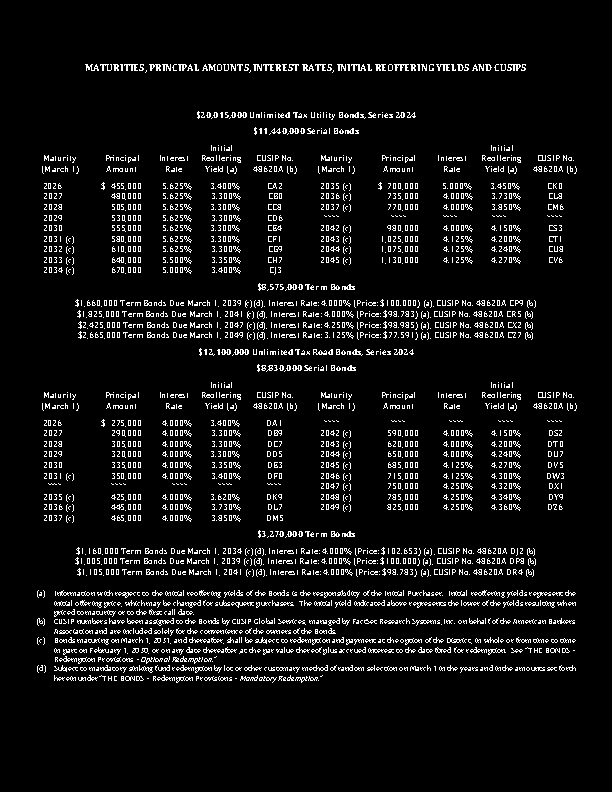

dilate_image


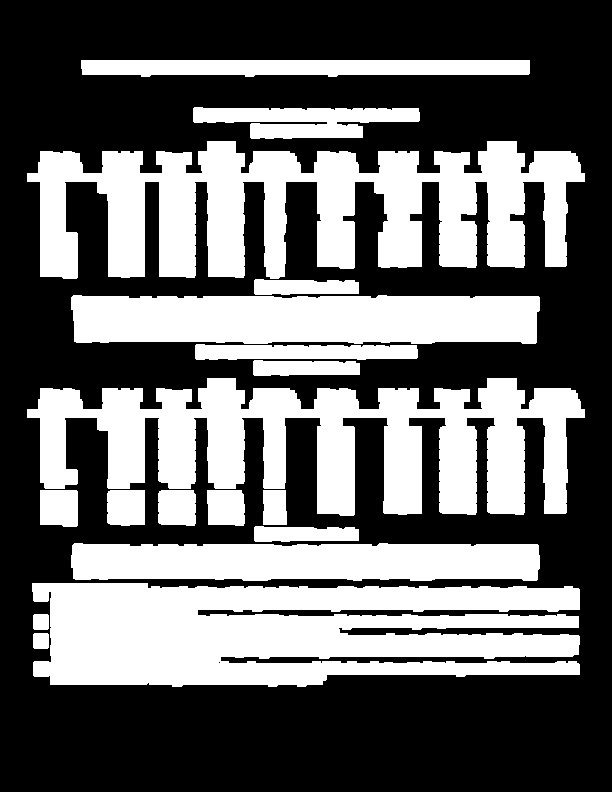

convert_contours_to_bounding_boxes


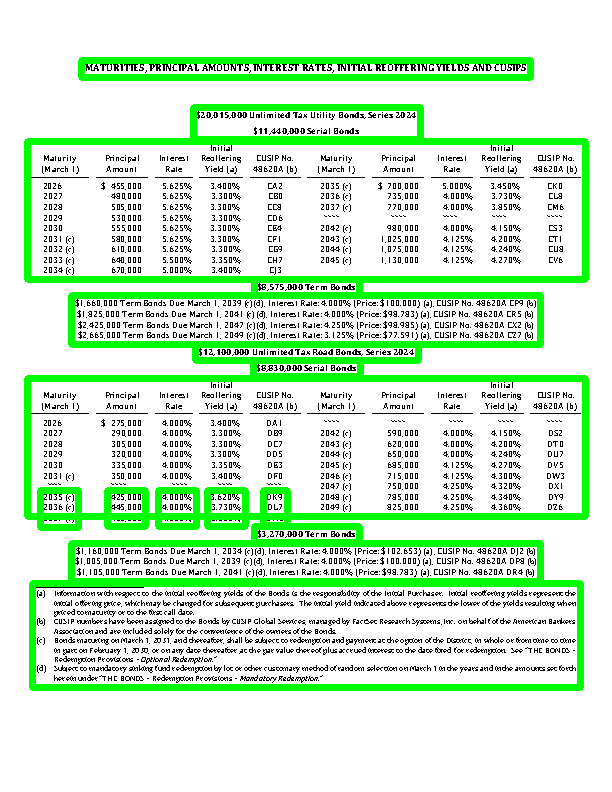

gridless_table pre-filtering and merge


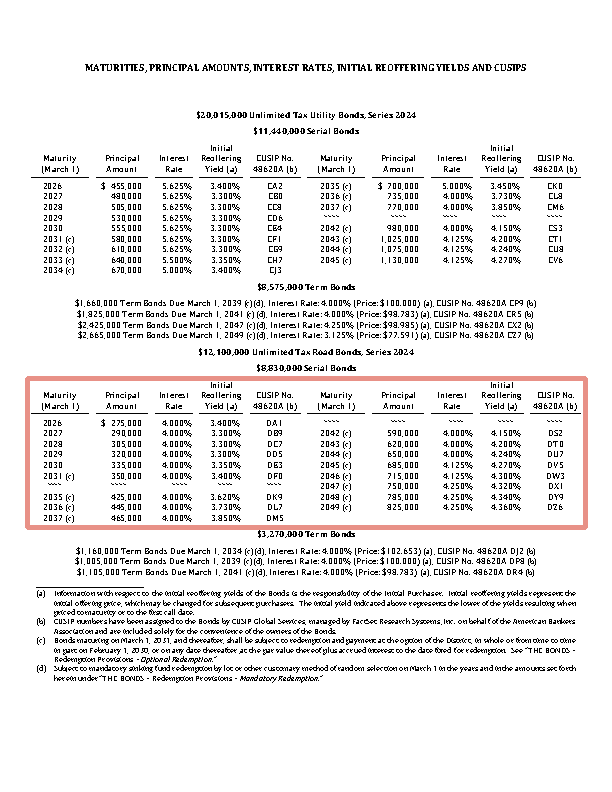

Skipping small bbox
Skipping small bbox
dilate_image WO lines


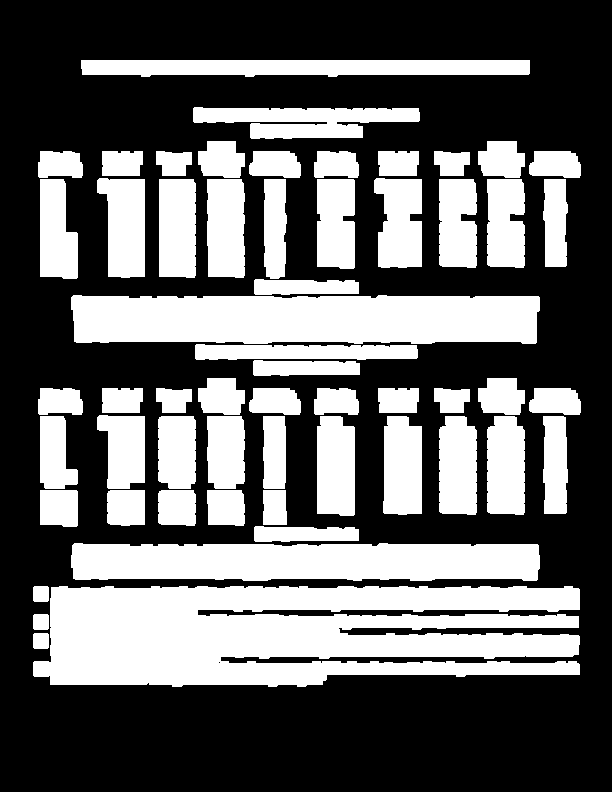

semigrid_bbox_img


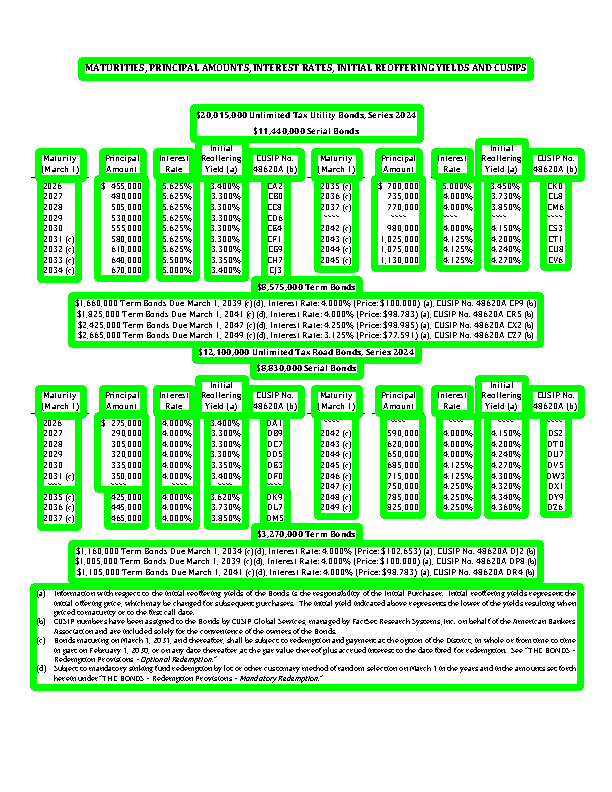

semigrid_bbox colored


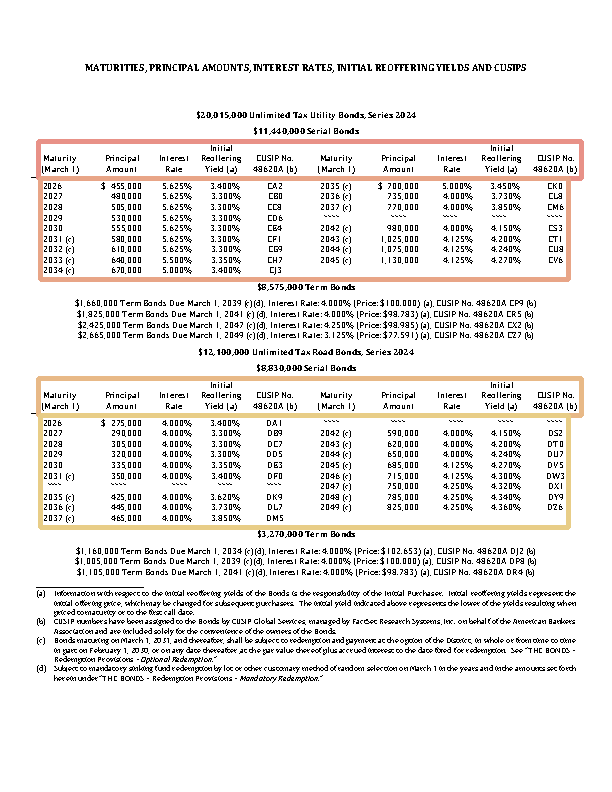

===============MERGED BOX REMOVED (38, 141, 543, 37) ===============
===============MERGED BOX PRESENT (40, 178, 528, 101) ===============
===============POSSIBLE SIBLING FOUND FOR (40, 178, 528, 101) is 38, 141 ===============
===============MERGED BOX REMOVED (38, 378, 543, 37) ===============
===============MERGED BOX PRESENT (40, 415, 528, 112) ===============
===============POSSIBLE SIBLING FOUND FOR (40, 415, 528, 112) is 38, 378 ===============
=========APPENDING TO  MASTER LIST============
=================VERTICAL SIBLINGS===================
[[(38, 378, 543, 37), (40, 415, 528, 112)]]
==============MERGED BOX (38, 378, 543, 149)====================


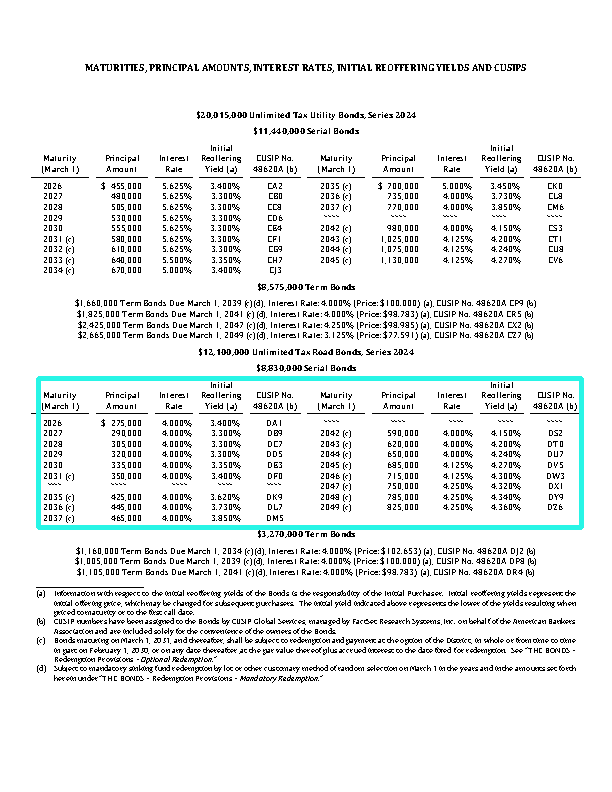

===============MERGED BOX PRESENT (27, 378, 558, 149) ===============
=================VERTICAL SIBLINGS===================
[]


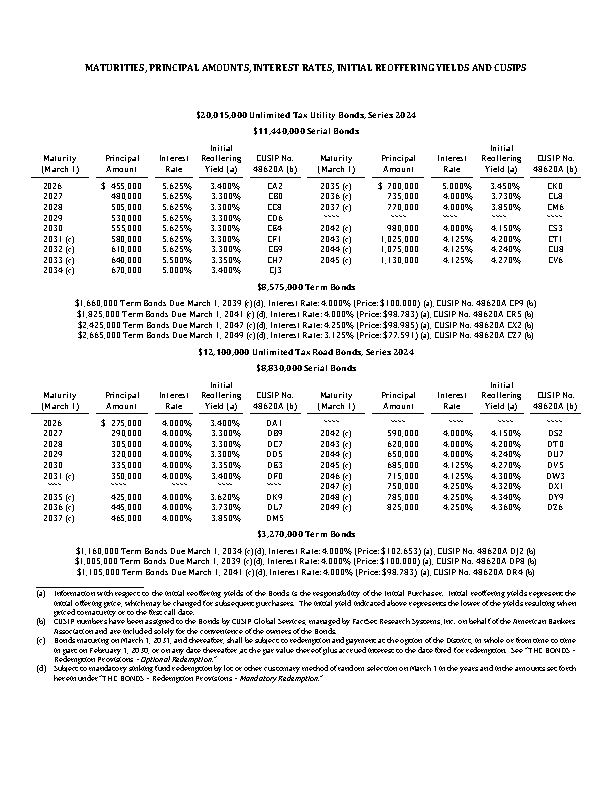

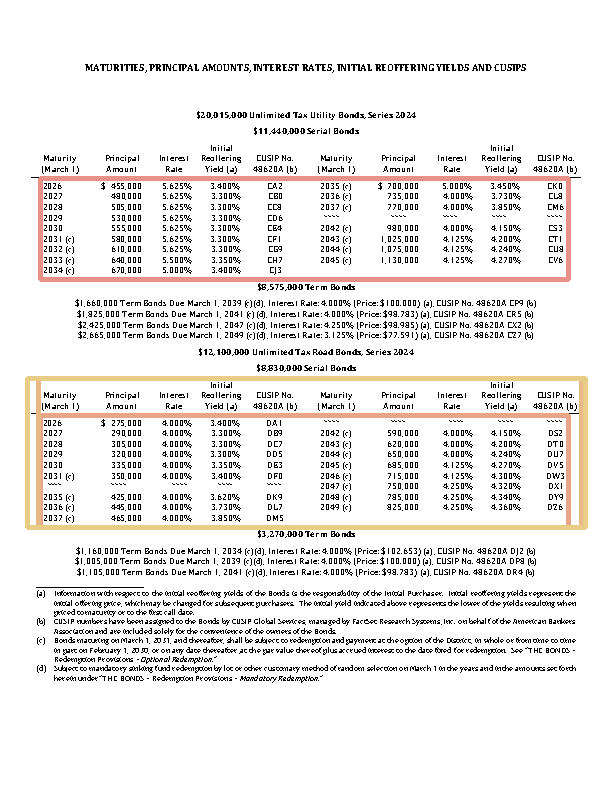

FINAL


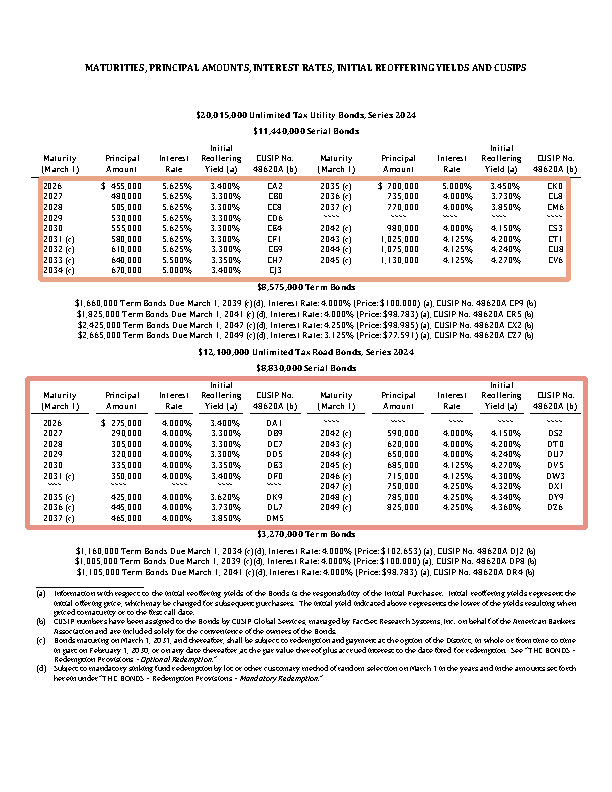

Area: (178, 40, 279, 568)
       2026   $  455,000  5.625%  3.400%  CA2  2035 (c)  $ 700,000  \
0      2027 NaN  480,000  5.625%  3.300%  CB0  2036 (c)    735,000   
1      2028 NaN  505,000  5.625%  3.300%  CC8  2037 (c)    770,000   
2      2029 NaN  530,000  5.625%  3.300%  CD6      ****       ****   
3      2030 NaN  555,000  5.625%  3.300%  CE4  2042 (c)    980,000   
4  2031 (c) NaN  580,000  5.625%  3.300%  CF1  2043 (c)  1,025,000   

   Unnamed: 8  5.000%  3.450%   CK0  
0         NaN  4.000%  3.730%   CL8  
1         NaN  4.000%  3.850%   CM6  
2         NaN    ****    ****  ****  
3         NaN  4.000%  4.150%   CS3  
4         NaN  4.125%  4.200%   CT1  
Area: (378, 27, 527, 585)
  Unnamed: 0 Unnamed: 1 Unnamed: 2     Initial  Unnamed: 4 Unnamed: 5  \
0   Maturity  Principal   Interest  Reoffering   CUSIP No.   Maturity   
1  (March 1)     Amount       Rate   Yield (a)  48620A (b)  (March 1)   
2       2026  $ 275,000     4.000%      3.400%         DA1       ****   
3      

NameError: name 'mongo_collection' is not defined

In [6]:

id = "P21765896-P21355688-P21792343"
PDF_FILE = f"/OTTO-Project/EMMA_OFFICIAL_STATEMENT_TEMP_PDF/{id}.pdf"

extractor = TableExtractor(PDF_FILE)

df_map = extractor.extract_tables(page_range=[1])

with open(f'/home/factentry/otto_ml/src/antlr/mondal/pdf_table_extractor/{id}.csv', 'w+') as f:
    print(f'"File Name","{PDF_FILE}"', file=f)


header_keywords = [
    "date",
    "maturity",
    "cusip",
    "principal",
    "amount",
    "interest"
]


for page_no, dfs in df_map.items():
    for df in dfs:
        if df.shape[1] == 1:
            continue
        if not df.shape[0]:
            continue

        if len(df.iloc[0]) < 2:
            continue

        row_count = df.shape[0]

        is_line = False

        for ri in range(row_count):
            words = str(df.iloc[ri][0]).split()
            avg_word_length = sum(len(word) for word in words) / len(words)
            if len(words) > 10 and avg_word_length > 5:
                is_line = True
                continue
        
        if is_line:
            continue

        # # print(df.head())

        # if not any(word in "".join(df.columns.values.tolist()).strip().lower() for word in header_keywords):
        #     # print(df.head())
        #     continue
            # # If there is no row, skip it
            # if not df.shape[0]:
            #     continue
            # # If it has row but first row's first cell is having more than 5 words, skip it as it's a paragraph
            # elif len(df.iloc[0]) and len(str(df.iloc[0][0]).split()) > 5:
            #     continue
        with open(f'/home/factentry/otto_ml/src/antlr/mondal/pdf_table_extractor/{id}.csv', 'a') as f:
            # print(f'\n', file=f)
            header_list = list(df.columns.values)
            header_list = ["" if header.lower().startswith("unnamed") else header for header in header_list]
            df.to_csv(f, index=False, header=header_list)
            mongo_collection.insert_many(df.to_dict('records'))



